#Generative Adversarial Network (GAN)
GANs are a form of neural network in which two sub-networks (the encoder and decoder) are trained on opposing loss functions: an encoder that is trained to produce data which is indiscernable from the true data, and a decoder that is trained to discern between the data and generated data.

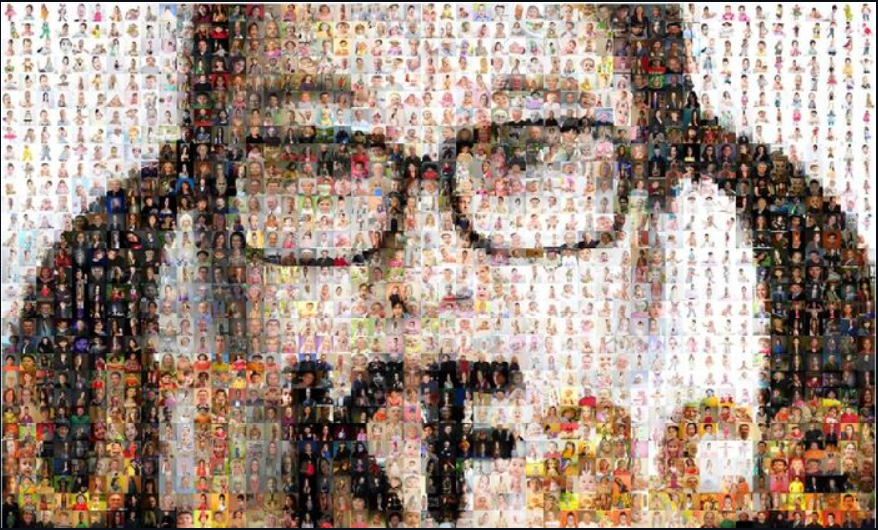



### Install packages if in colab

In [ ]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
#colab_requirements = ["pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513"]
#if IN_COLAB:
#    for i in colab_requirements:
#        run_subprocess_command(i)

### load packages

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


#UTKFace data can get from here:

 https://drive.google.com/file/d/0BxYys69jI14kYVM3aVhKS1VhRUk/view?usp=sharing

In [ ]:
# Google drive link stored at drive & then extracted
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.__version__)

2.4.1


#Get UTKFace Dataset

In [ ]:
!tar xzf /content/drive/MyDrive/NLP_iNeuron/UTKface_AlignedCropped/UTKFace.tar.gz

In [ ]:
dataset_folder_name = 'UTKFace'

TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 192

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

In [ ]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df

In [ ]:
df = parse_dataset(dataset_folder_name)
df.head()

,age,gender,race,file
0,22.0,male,white,UTKFace/22_0_0_20170104230045815.jpg.chip.jpg
1,31.0,female,indian,UTKFace/31_1_3_20170104223314431.jpg.chip.jpg
2,27.0,female,white,UTKFace/27_1_0_20170117120649662.jpg.chip.jpg
3,1.0,male,indian,UTKFace/1_0_3_20161220144649151.jpg.chip.jpg
4,24.0,female,asian,UTKFace/24_1_2_20170116162908737.jpg.chip.jpg


In [ ]:
from keras.utils import to_categorical
from PIL import Image

class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]

        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])

        self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, ages, races, genders = [], [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
                race = person['race_id']
                gender = person['gender_id']
                file = person['file']
                
                im = self.preprocess_image(file)
                
                ages.append(age / self.max_age)
                races.append(to_categorical(race, len(dataset_dict['race_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                    images, ages, races, genders = [], [], [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

#Data preparation
In order to input our data to our Keras multi-output model, we will create a helper object to work as a data generator for our dataset. This will be done by generating batches of data, which will be used to feed our multi-output model.

In [ ]:
df1 = df.copy()

## Only chid data age<=5 used for training the model

In [ ]:
df = df.loc[df['age']<=5]

In [ ]:
len(df['age'])

2363

In [ ]:
df.head()

,age,gender,race,file,gender_id,race_id
11,3.0,female,asian,UTKFace/3_1_2_20161219190118219.jpg.chip.jpg,1,2
18,1.0,female,asian,UTKFace/1_1_2_20161219200451724.jpg.chip.jpg,1,2
35,1.0,male,asian,UTKFace/1_0_2_20161219204024196.jpg.chip.jpg,0,2
36,2.0,female,white,UTKFace/2_1_0_20170109193728905.jpg.chip.jpg,1,0
37,2.0,male,others,UTKFace/2_0_4_20170103205319954.jpg.chip.jpg,0,4


In [ ]:
pcs_img = []
for i in df['file']:
  img = data_generator.preprocess_image(i)

  pcs_img.append(img)

pcs_img = np.array(pcs_img)

In [ ]:
pcs_img.shape[1]

192

In [ ]:
# split dataset
train_images = pcs_img[:1655]
test_images = pcs_img[1655:]


# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
)

In [ ]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(192,192,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 3 * 3
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((3, 3, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 64x64
	model.add(Conv2DTranspose(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 # upsample to 128x128
	model.add(Conv2DTranspose(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 # upsample to 256x256
	model.add(Conv2DTranspose(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
  # output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):#, d_model
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 192, 192, 3)       1269123   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 665857    
Total params: 1,934,980
Trainable params: 1,269,123
Non-trainable params: 665,857
_________________________________________________________________


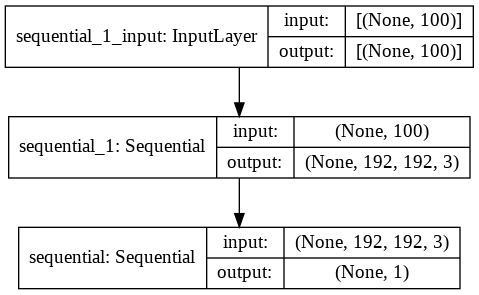

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)#, d_model
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

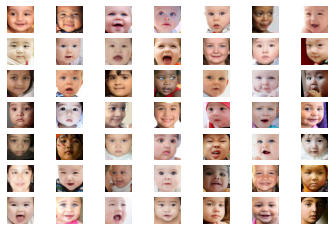

In [ ]:
from matplotlib import pyplot
# plot images from the training dataset
for i in range(49):
	# define subplot
	pyplot.subplot(7, 7, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(train_images[i])
pyplot.show()

In [ ]:
# convert from unsigned ints to floats
X = pcs_img.astype('float32')
X.shape

(2363, 192, 192, 3)

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import randn
from numpy.random import rand
from numpy.random import randint

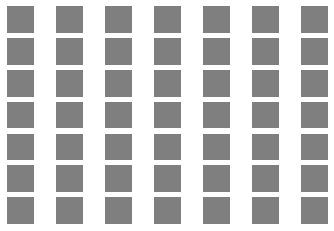

In [ ]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 49
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(7, 7, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i])
# show the figure
pyplot.show()

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	if (i+1) % 100 == 0:
		filename = 'generator_model_%03d.h5' % (epoch+1)
		g_model.save(filename)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=112):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 100 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = pcs_img
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/21, d1=0.684, d2=0.696 g=0.694
>1, 2/21, d1=0.300, d2=0.696 g=0.698
>1, 3/21, d1=0.049, d2=0.689 g=0.711
>1, 4/21, d1=0.007, d2=0.673 g=0.733
>1, 5/21, d1=0.003, d2=0.650 g=0.771
>1, 6/21, d1=0.002, d2=0.613 g=0.847
>1, 7/21, d1=0.001, d2=0.544 g=1.017
>1, 8/21, d1=0.002, d2=0.415 g=1.430
>1, 9/21, d1=0.001, d2=0.227 g=2.275
>1, 10/21, d1=0.010, d2=0.093 g=3.155
>1, 11/21, d1=0.001, d2=0.038 g=3.963
>1, 12/21, d1=0.000, d2=0.020 g=4.531
>1, 13/21, d1=0.005, d2=0.017 g=4.725
>1, 14/21, d1=0.000, d2=0.017 g=5.416
>1, 15/21, d1=0.000, d2=0.006 g=6.833
>1, 16/21, d1=0.000, d2=0.002 g=7.900
>1, 17/21, d1=0.009, d2=0.049 g=12.502
>1, 18/21, d1=0.002, d2=0.000 g=14.050
>1, 19/21, d1=0.380, d2=0.010 g=1.851
>1, 20/21, d1=0.000, d2=2.185 g=1.703
>1, 21/21, d1=0.000, d2=0.505 g=3.413
>2, 1/21, d1=0.001, d2=0.134 g=4.857
>2, 2/21, d1=0.012, d2=0.074 g=6.466
>2, 3/21, d1=0.194, d2=1.191 g=11.496
>2, 4/21, d1=5.599, d2=1.140 g=2.252
>2, 5/21, d1=0.338, d2=0.336 g=2.627
>2, 6/21, d1=0.176, d2=

In [ ]:
summarize_performance(200, g_model, d_model, dataset, latent_dim)

>Accuracy real: 69%, fake: 99%


In [ ]:
g_model.save("/content/sample_data/GNA_400pch.h5")

In [ ]:
!cp -av /content/sample_data/GNA_400pch.h5 /content/drive/MyDrive/AdVision/GAN

'/content/sample_data/GNA_400pch.h5' -> '/content/drive/MyDrive/AdVision/GAN/GNA_400pch.h5'


# Evaluating our model on the test set
In order to assess how our model performs on the test set, let's use our UTK data generator class, but this time using the test indexes. We will then call the predict_generator method from our trained model, which will output our the predictions for the test set.

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 

In [ ]:
# load model
model = load_model('/content/drive/MyDrive/AdVision/GAN/GAN_400pch.h5')
# generate images
latent_points = generate_latent_points(100, 50)

In [ ]:
latent_points.shape

(50, 100)

In [ ]:
latent_points[0][1]

-0.2950886731741321

In [ ]:
latent_points

array([[ 0.32609898, -0.82019708, -1.64240045, ...,  0.44696439,
         3.11859842, -1.00734404],
       [-0.30276689, -0.62638012, -0.23160776, ..., -0.86711317,
         1.22896806, -0.54421494],
       [ 1.89549558, -0.35350032, -0.19471268, ...,  0.30129158,
        -0.09258809, -0.35401436],
       ...,
       [ 1.27701767, -0.95073282, -0.14137047, ...,  0.89469769,
        -0.31311449, -0.72609841],
       [ 2.28615365, -1.16516243, -0.72605947, ..., -0.68787514,
         1.37243447, -1.61542031],
       [-0.49398309, -1.50542099,  1.42936001, ..., -1.19932104,
        -0.07021857,  0.71545872]])

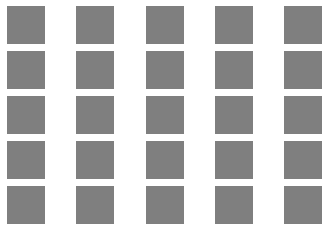

In [ ]:
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
#create_plot(X, int(latent_points.shape[0]/10))
create_plot(X, 5)

In [ ]:
/content/drive/MyDrive/AdVision/GAN/facMe.jpg

In [ ]:
imBh =Image.open('/content/drive/MyDrive/AdVision/GAN/faceBh.jpg')
imBh = imBh.resize((6, 6))
imBh = np.array(imBh) / 255.0
imMe =Image.open('/content/drive/MyDrive/AdVision/GAN/facMe.jpg')
imMe = imMe.resize((6, 6))
imMe = np.array(imMe) / 255.0

In [ ]:
imBh.resize(108,1)
imMe.resize(108,1)

In [ ]:
im.shape

(108, 1)

In [ ]:
im[1][0]

0.7568627450980392

In [ ]:
latent_points1 = latent_points

In [ ]:
latent_points1.shape

(1, 100)

In [ ]:
for i in range(0, latent_points.shape[1]):
  latent_points[0][i] = imBh[i][0]*imBh[i][0]

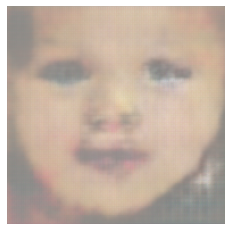

In [ ]:
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
#create_plot(X, int(latent_points.shape[0]/10))
create_plot(X, 1)

In [ ]:
# load model
model = load_model('GAN_400pch.h5')
# generate images
latent_points = generate_latent_points(100, 1)

In [ ]:
for i in range(0, latent_points.shape[1]):
  latent_points[0][i] = imMe[i][0]+imBh[i][0]

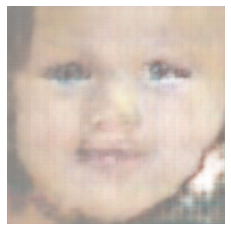

In [ ]:
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
#create_plot(X, int(latent_points.shape[0]/10))
create_plot(X, 1)

# split dataset
train_images = train_images.reshape(28, 28, 3).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(28, 28, 3).astype("float32") / 255.0


In [ ]:
test_dataset, train_dataset

(<BatchDataset shapes: (None, 198, 198, 3), types: tf.float64>,
 <BatchDataset shapes: (None, 198, 198, 3), types: tf.float64>)

In [ ]:
len(train_images),len(test_images)

(1655, 708)

In [ ]:
len(train_dataset),len(test_dataset)

(26, 12)

### Define the network as tf.keras.model object

In [ ]:
class GAN(tf.keras.Model):
    """ a basic GAN class 
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 49, 49, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ### losses
        # losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)
        
        
def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels
    """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )


### Define the network architecture

In [ ]:
DIMS

(198, 198, 3)

In [ ]:
N_Z = 64
generator = [
    tf.keras.layers.Dense(units=7* 7* 64, activation="relu"),
    #tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=3, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

In [ ]:
pwd

'/content'

### Create Model

In [ ]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
# model
model = GAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z
)

### Train the model

In [ ]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    print(nex, 1, zm * nex, zm)
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [ ]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

In [ ]:
train_dataset

<BatchDataset shapes: (None, 198, 198, 3), types: tf.float64>

In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
n_epochs = 200
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES):
      
      model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    # save the generator model tile file
    if epoch%10 == 0:
      filename = 'GAN_model_%03d.h5py' % epoch
      model.save(filename)
    #plot_reconstruction(model)

In [ ]:
filename = 'GAN_model_%03d.h5py' % epoch
model.save_weights(filename)

In [ ]:
model.predict(x)
tf.saved_model.save(filename,save_format="tf")

NameError: ignored

In [ ]:
filename

'GAN_model_000.h5'

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

In [ ]:
del model

In [ ]:
# load weights into new model

model = load_model('GAN_model_000.h5py', custom_objects={'resblock': GAN})
print("Loaded model from disk")


OSError: ignored

In [ ]:
# load model
model = model.load_weights('GAN_model_100.h5')


ValueError: ignored

In [ ]:
# generate images
latent_points = generate_latent_points(100, 100)